In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('series.csv')
df.head()

,X,Y
0,0.0,-0.051319
1,1.0,0.106921
2,2.0,0.282221
3,3.0,0.375320
4,4.0,0.472221


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x = df['X'].values.reshape(-1, 1)
y = df['Y'].values.reshape(-1, 1)

poly_features = PolynomialFeatures(degree=18)
x_fit = poly_features.fit_transform(x)


# Fit the linear regression model
model = LinearRegression()
model.fit(x_fit, y)


y_pred = model.predict(x_fit)

mse = mean_squared_error(y, y_pred)

model_coef = model.coef_
model_intercept = model.intercept_

mse, model_intercept, model_coef

(0.5991795587373973,
 array([1.31163251]),
 array([[ 0.00000000e+00,  7.16613095e-32,  1.59154823e-35,
          7.61775654e-39,  3.44277137e-42,  4.16434488e-51,
          7.25241202e-44,  8.25739710e-42,  9.02183746e-40,
          9.33822566e-38,  8.99550368e-36,  7.83923097e-34,
          5.88552448e-32,  3.45374475e-30,  1.22167442e-28,
         -2.48413732e-30,  1.90680194e-32, -6.54491626e-35,
          8.47004218e-38]]))

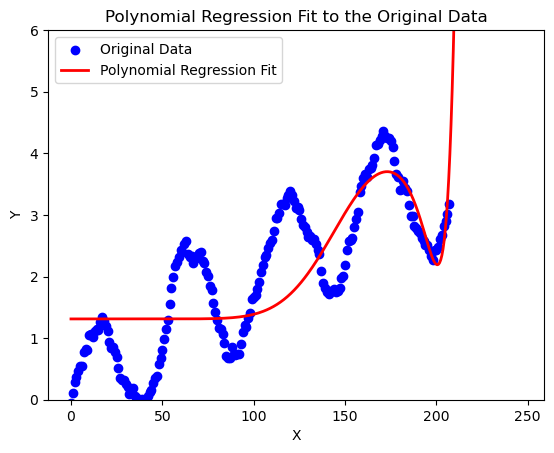

In [4]:
import matplotlib.pyplot as plt
x_extended = np.linspace(df['X'].min(), 250, 400).reshape(-1, 1)  # Reshaped for sklearn
poly_features = PolynomialFeatures(degree=18)

# Transforming the extended x-values to polynomial features
x_extended_poly = poly_features.fit_transform(x_extended)

# Making predictions over the extended range
y_extended_pred = model.predict(x_extended_poly)

# Plotting the original data
plt.scatter(df['X'], df['Y'], color='blue', label='Original Data')

# Plotting the regression model predictions over the extended range
plt.plot(x_extended, y_extended_pred, color='red', label='Polynomial Regression Fit', linewidth=2)

plt.title('Polynomial Regression Fit to the Original Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0, 6)
plt.xlim(right=259)  # Extending the x-axis to 250
plt.legend()
plt.show()

Well let's not be too crazy, just do a radical + periodic to capture the similarity and the pedioridic

Optimized kernel: 1.24**2 * RBF(length_scale=17.6) + 1.09**2 * RBF(length_scale=102) * ExpSineSquared(length_scale=1, periodicity=1) + 0.321**2 * RationalQuadratic(alpha=0.0395, length_scale=5.59) + 0.0212**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.000451)
Log-marginal-likelihood: 241.622


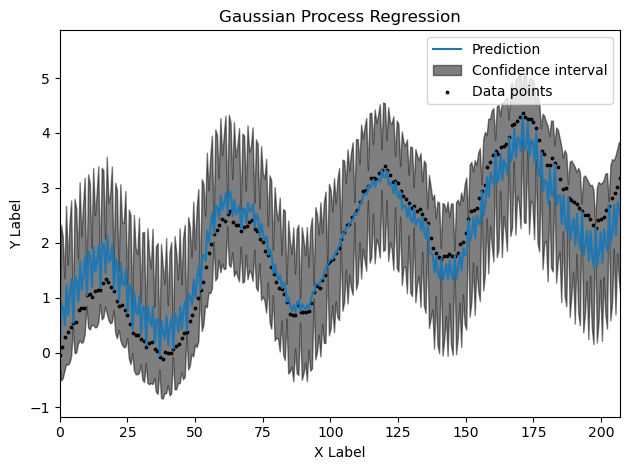

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

#k1 = 2**2 * RBF(length_scale=50)  # long-term smooth trend
#k2 = 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1.0, periodicity=1.0,periodicity_bounds="fixed")  # seasonal component
# kernel
k1 = 50.0**2 * RBF(length_scale=50.0)  # long-term, smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium-term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf))  # noise
kernel = k1 + k2 + k3 + k4
#kernel = k1 + k2

# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True)

# Fit the model
gp.fit(x, y)

# After fitting, the kernel_ attribute will have the optimized kernel parameters
print("Optimized kernel:", gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


y_pred, y_std = gp.predict(x_extended, return_std=True)

# Visualize predictions
plt.plot(x_extended, y_pred, label='Prediction')
plt.fill_between(x_extended[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5, color='k', label='Confidence interval')
# Ensure to use the original 'x' for plotting against 'y'
plt.scatter(x, y, c='k', s=3, label='Data points')
plt.xlim(x.min(), x.max())
plt.xlabel("X Label")
plt.ylabel("Y Label")
plt.title("Gaussian Process Regression")
plt.legend()
plt.tight_layout()
plt.show()

I started with a simple kernel using only K1+K2, as I thought a periodic trick would suffice. However, the regression results were subpar using only those kernels. The log marginal likelihood was negative, and the prediction panel resembled a rectangle, suggesting the periodic kernel had little effect. Therefore, I reverted to the original kernel design from the PPT, as it included automatic parameter optimization. This resulted in more reasonable results.

I believe Gaussian processes are highly sensitive to kernel design. A poorly designed kernel can yield results inferior to polynomial regression.

In my opinion, compiling a collection of "classical" kernel formulas for various "interesting" data patterns would be extremely helpful for real-world applications. And I would also hope to get more examples of iconic kernel design for intersting data patterns in class if possible.